In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
from collections import defaultdict
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
print("Libraries loaded.")

Libraries loaded.


In [2]:
barley = pd.read_csv('cleaned_barley_data.csv')
barley = barley.drop(columns=['Unnamed: 0'], errors='ignore')

print(f"Shape: {barley.shape}")
print(f"Departments: {barley['department'].nunique()}")
print(f"Years: {barley['year'].min()} — {barley['year'].max()}")
print(f"\nNull values:\n{barley.isnull().sum()}")
print(f"\nYield stats:")
print(barley['yield'].describe())
barley.head()

Shape: (3583, 5)
Departments: 97
Years: 1982 — 2018

Null values:
department      0
year            0
yield         122
area          115
production    122
dtype: int64

Yield stats:
count    3461.000000
mean        5.211611
std         1.410576
min         0.813560
25%         4.218820
50%         5.244440
75%         6.233790
max         9.434165
Name: yield, dtype: float64


,department,year,yield,area,production
0,Ain,1982,3.950080,16065.0,63458.0
1,Ain,1983,2.648276,14500.0,38400.0
2,Ain,1984,4.822580,15500.0,74750.0
3,Ain,1985,4.196770,15500.0,65050.0
4,Ain,1986,3.598450,12900.0,46420.0


In [3]:
parquet_file = pq.ParquetFile('climate_data_from_1982.parquet')

agg_annual = defaultdict(lambda: {'sum': 0.0, 'count': 0})
agg_gs = defaultdict(lambda: {'sum': 0.0, 'count': 0})

for i in range(parquet_file.metadata.num_row_groups):
    chunk = parquet_file.read_row_group(
        i, columns=['scenario', 'nom_dep', 'year', 'time', 'metric', 'value']
    ).to_pandas()
    chunk = chunk[chunk['scenario'] == 'historical']
    if len(chunk) == 0:
        print(f"Row group {i}: no historical data, skipped")
        continue

    # --- Annual aggregation ---
    grouped = chunk.groupby(['nom_dep', 'year', 'metric'])['value'].agg(['sum', 'count'])
    for idx, row in grouped.iterrows():
        agg_annual[idx]['sum'] += row['sum']
        agg_annual[idx]['count'] += row['count']

    # --- Growing season (Mar–Jul) aggregation ---
    chunk['month'] = pd.to_datetime(chunk['time']).dt.month
    chunk_gs = chunk[chunk['month'].between(3, 7)]
    if len(chunk_gs) > 0:
        grouped_gs = chunk_gs.groupby(['nom_dep', 'year', 'metric'])['value'].agg(['sum', 'count'])
        for idx, row in grouped_gs.iterrows():
            agg_gs[idx]['sum'] += row['sum']
            agg_gs[idx]['count'] += row['count']

    print(f"Row group {i} done ({len(chunk):,} historical rows)")

print("\nAggregation complete.")
print(f"Annual keys:         {len(agg_annual):,}")
print(f"Growing season keys: {len(agg_gs):,}")

Row group 0 done (1,048,576 historical rows)
Row group 1 done (1,048,576 historical rows)
Row group 2 done (1,048,576 historical rows)
Row group 3 done (72,423 historical rows)
Row group 4: no historical data, skipped
Row group 5: no historical data, skipped
Row group 6: no historical data, skipped
Row group 7: no historical data, skipped
Row group 8: no historical data, skipped
Row group 9: no historical data, skipped
Row group 10: no historical data, skipped
Row group 11: no historical data, skipped
Row group 12: no historical data, skipped

Aggregation complete.
Annual keys:         8,811
Growing season keys: 8,811


In [4]:
def build_climate_df(agg_dict, prefix=''):
    records = []
    for (dep, year, metric), v in agg_dict.items():
        records.append({
            'department': dep,
            'year': int(year),
            'metric': metric,
            'mean_value': v['sum'] / v['count'] if v['count'] > 0 else None
        })
    df = pd.DataFrame(records)
    pivot = df.pivot_table(index=['department', 'year'], columns='metric', values='mean_value').reset_index()
    pivot.columns.name = None

    # Rename
    pivot = pivot.rename(columns={
        'near_surface_air_temperature': f'{prefix}temp_mean',
        'daily_maximum_near_surface_air_temperature': f'{prefix}temp_max',
        'precipitation': f'{prefix}precip'
    })

    # Convert units: Kelvin → °C, m/day → mm/day
    pivot[f'{prefix}temp_mean'] = pivot[f'{prefix}temp_mean'] - 273.15
    pivot[f'{prefix}temp_max'] = pivot[f'{prefix}temp_max'] - 273.15
    pivot[f'{prefix}precip'] = pivot[f'{prefix}precip'].clip(lower=0) * 1000

    return pivot

climate_annual = build_climate_df(agg_annual, prefix='')
climate_gs = build_climate_df(agg_gs, prefix='gs_')

print(f"Annual climate: {climate_annual.shape}")
print(climate_annual.head())
print(f"\nGrowing season climate: {climate_gs.shape}")
print(climate_gs.head())

Annual climate: (2937, 5)
  department  year   temp_max  temp_mean    precip
0        Ain  1982  14.332663   9.629238  0.075327
1        Ain  1983  13.083797   8.573994  0.079486
2        Ain  1984  13.492930   8.904197  0.075905
3        Ain  1985  12.979987   8.529645  0.093715
4        Ain  1986  14.162971   9.271490  0.065630

Growing season climate: (2937, 5)
  department  year  gs_temp_max  gs_temp_mean  gs_precip
0        Ain  1982    16.836520     11.995348   0.083134
1        Ain  1983    16.087030     11.331975   0.081747
2        Ain  1984    16.997238     11.959171   0.087477
3        Ain  1985    15.996701     11.119710   0.088224
4        Ain  1986    16.717545     11.808129   0.067555


In [5]:
barley_deps = set(barley['department'].unique())
climate_deps = set(climate_annual['department'].unique())

# Normalize names for fuzzy matching
def normalize(name):
    return name.lower().replace('_', '').replace('-', '').replace(' ', '').replace("'", "").replace("è", "e").replace("é", "e").replace("ô", "o").replace("î", "i")

barley_norm = {normalize(d): d for d in barley_deps}
climate_to_barley = {}
unmatched = []

for cd in climate_deps:
    cn = normalize(cd)
    if cn in barley_norm:
        climate_to_barley[cd] = barley_norm[cn]
    else:
        unmatched.append(cd)

print(f"Matched: {len(climate_to_barley)} departments")
if unmatched:
    print(f"Unmatched climate departments ({len(unmatched)}): {sorted(unmatched)}")

only_barley = barley_deps - set(climate_to_barley.values())
if only_barley:
    print(f"Barley departments with no climate match ({len(only_barley)}): {sorted(only_barley)}")

# Apply mapping
climate_annual['department'] = climate_annual['department'].map(climate_to_barley)
climate_gs['department'] = climate_gs['department'].map(climate_to_barley)

climate_annual = climate_annual.dropna(subset=['department'])
climate_gs = climate_gs.dropna(subset=['department'])

# Merge
df = barley.merge(climate_annual, on=['department', 'year'], how='inner')
df = df.merge(climate_gs, on=['department', 'year'], how='inner')

# Drop rows missing yield or any climate variable
all_climate_cols = ['temp_mean', 'temp_max', 'precip', 'gs_temp_mean', 'gs_temp_max', 'gs_precip']
df_clean = df.dropna(subset=['yield'] + all_climate_cols)

print(f"\nMerged shape (raw):   {df.shape}")
print(f"Merged shape (clean): {df_clean.shape}")
print(f"Departments: {df_clean['department'].nunique()}")
print(f"Years: {df_clean['year'].min()} — {df_clean['year'].max()}")
df_clean.head()

Matched: 89 departments
Barley departments with no climate match (8): ['Corse_du_Sud', 'Haute_Corse', 'Hauts_de_Seine', 'Paris', 'Seine_Saint_Denis', 'Seine_SeineOise', 'Val_d_Oise', 'Val_de_Marne']

Merged shape (raw):   (2937, 11)
Merged shape (clean): (2935, 11)
Departments: 89
Years: 1982 — 2014


,department,year,yield,area,production,temp_max,temp_mean,precip,gs_temp_max,gs_temp_mean,gs_precip
0,Ain,1982,3.950080,16065.0,63458.0,14.332663,9.629238,0.075327,16.836520,11.995348,0.083134
1,Ain,1983,2.648276,14500.0,38400.0,13.083797,8.573994,0.079486,16.087030,11.331975,0.081747
2,Ain,1984,4.822580,15500.0,74750.0,13.492930,8.904197,0.075905,16.997238,11.959171,0.087477
3,Ain,1985,4.196770,15500.0,65050.0,12.979987,8.529645,0.093715,15.996701,11.119710,0.088224
4,Ain,1986,3.598450,12900.0,46420.0,14.162971,9.271490,0.065630,16.717545,11.808129,0.067555


=== Descriptive Statistics ===

           yield  temp_mean   temp_max     precip  gs_temp_mean  gs_temp_max  \
count  2935.0000  2935.0000  2935.0000  2935.0000     2935.0000    2935.0000   
mean      5.1616     9.8972    14.2427     0.0964       12.0471      16.7104   
std       1.3616     2.2018     2.2471     0.0424        2.2122       2.4382   
min       0.8136    -0.4845     3.9614     0.0161        1.4269       5.4657   
25%       4.2000     8.9821    13.1953     0.0656       11.0907      15.4666   
50%       5.1765    10.2030    14.3953     0.0920       12.3137      16.9756   
75%       6.1646    11.2387    15.6487     0.1206       13.4451      18.3400   
max       8.8071    15.0159    20.1260     0.2813       17.9995      23.1123   

       gs_precip  
count  2935.0000  
mean      0.0929  
std       0.0451  
min       0.0107  
25%       0.0606  
50%       0.0864  
75%       0.1172  
max       0.2937  


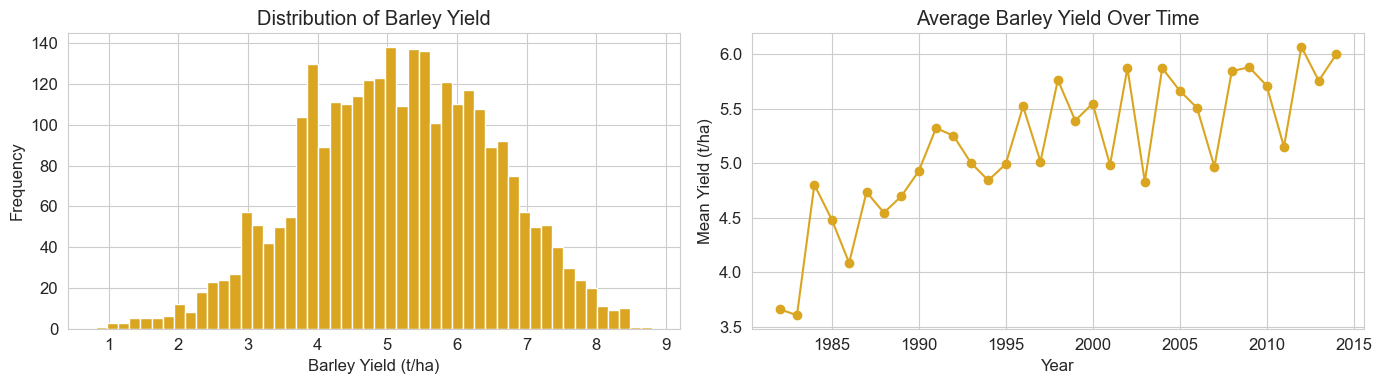

In [6]:
print("=== Descriptive Statistics ===\n")
print(df_clean[['yield', 'temp_mean', 'temp_max', 'precip',
                'gs_temp_mean', 'gs_temp_max', 'gs_precip']].describe().round(4))

# Yield distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(df_clean['yield'], bins=50, color='goldenrod', edgecolor='white')
axes[0].set_xlabel('Barley Yield (t/ha)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Barley Yield')

# Yield over time
yearly_yield = df_clean.groupby('year')['yield'].mean()
axes[1].plot(yearly_yield.index, yearly_yield.values, 'o-', color='goldenrod')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Mean Yield (t/ha)')
axes[1].set_title('Average Barley Yield Over Time')
plt.tight_layout()
plt.show()

PEARSON CORRELATION WITH BARLEY YIELD

--- Annual Averages ---
  temp_mean      :  r = +0.1637,  p = 4.35e-19  ***
  temp_max       :  r = +0.0915,  p = 6.77e-07  ***
  precip         :  r = -0.1929,  p = 5.34e-26  ***

--- Growing Season (Mar–Jul) ---
  gs_temp_mean   :  r = +0.1661,  p = 1.31e-19  ***
  gs_temp_max    :  r = +0.1404,  p = 2.16e-14  ***
  gs_precip      :  r = -0.2085,  p = 3.39e-30  ***


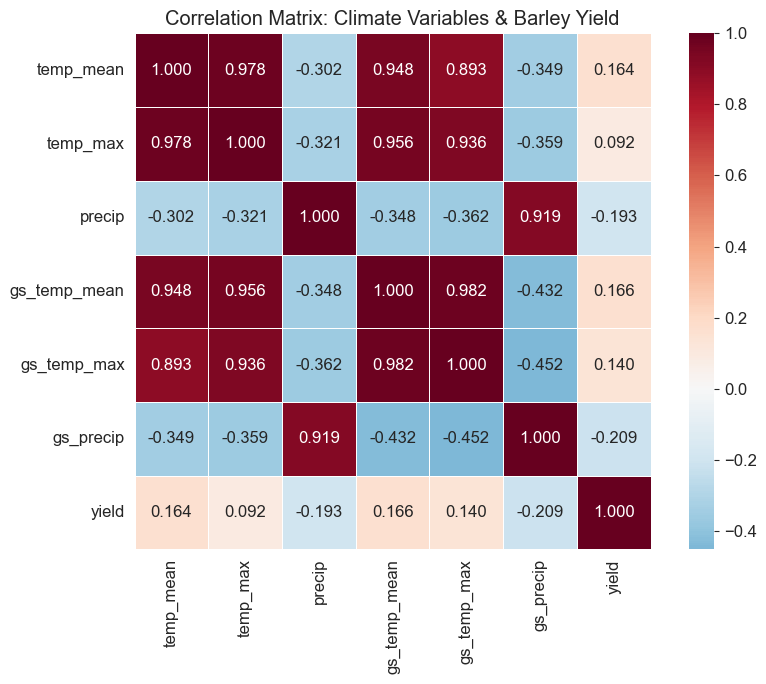

In [7]:
annual_vars = ['temp_mean', 'temp_max', 'precip']
gs_vars = ['gs_temp_mean', 'gs_temp_max', 'gs_precip']

print("=" * 60)
print("PEARSON CORRELATION WITH BARLEY YIELD")
print("=" * 60)

print("\n--- Annual Averages ---")
for var in annual_vars:
    r, p = stats.pearsonr(df_clean[var], df_clean['yield'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"  {var:15s}:  r = {r:+.4f},  p = {p:.2e}  {sig}")

print("\n--- Growing Season (Mar–Jul) ---")
for var in gs_vars:
    r, p = stats.pearsonr(df_clean[var], df_clean['yield'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"  {var:15s}:  r = {r:+.4f},  p = {p:.2e}  {sig}")

# Heatmap
corr_cols = annual_vars + gs_vars + ['yield']
corr_matrix = df_clean[corr_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix: Climate Variables & Barley Yield')
plt.tight_layout()
plt.show()

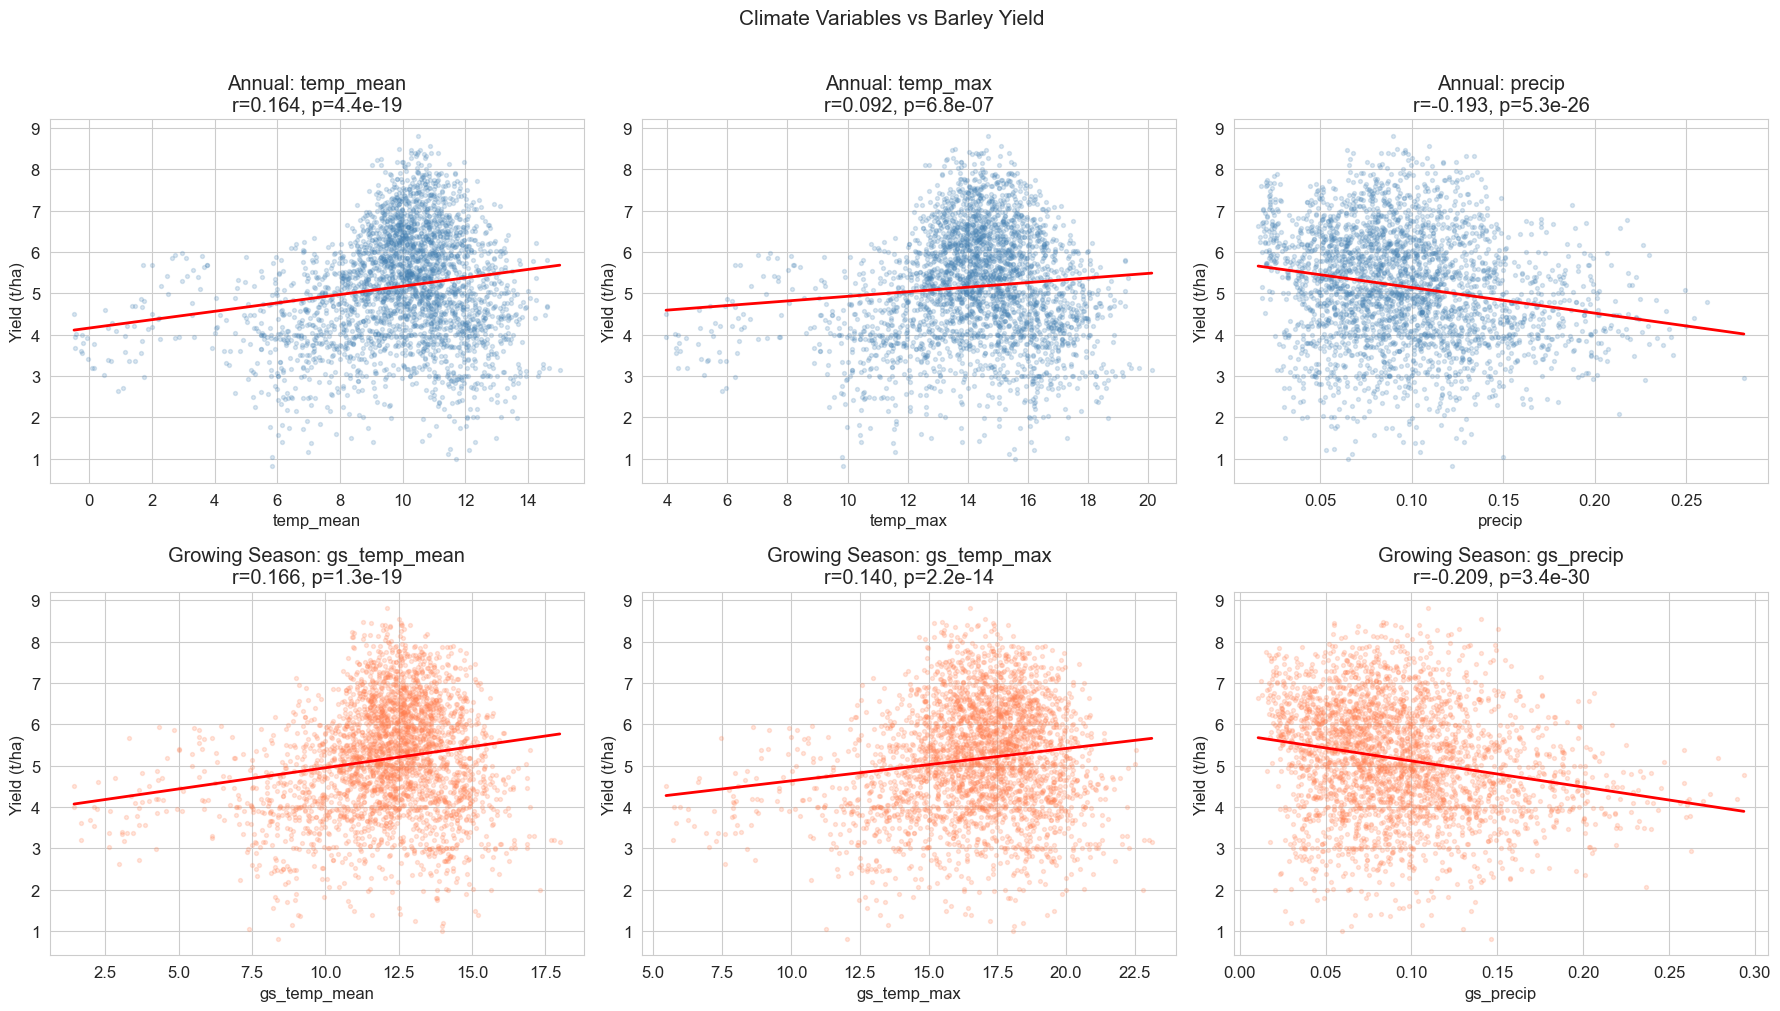

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(annual_vars):
    ax = axes[0][i]
    ax.scatter(df_clean[var], df_clean['yield'], alpha=0.2, s=8, color='steelblue')
    slope, intercept, r, p, se = stats.linregress(df_clean[var], df_clean['yield'])
    x_line = np.linspace(df_clean[var].min(), df_clean[var].max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
    ax.set_xlabel(var)
    ax.set_ylabel('Yield (t/ha)')
    ax.set_title(f'Annual: {var}\nr={r:.3f}, p={p:.1e}')

for i, var in enumerate(gs_vars):
    ax = axes[1][i]
    ax.scatter(df_clean[var], df_clean['yield'], alpha=0.2, s=8, color='coral')
    slope, intercept, r, p, se = stats.linregress(df_clean[var], df_clean['yield'])
    x_line = np.linspace(df_clean[var].min(), df_clean[var].max(), 100)
    ax.plot(x_line, slope * x_line + intercept, 'r-', linewidth=2)
    ax.set_xlabel(var)
    ax.set_ylabel('Yield (t/ha)')
    ax.set_title(f'Growing Season: {var}\nr={r:.3f}, p={p:.1e}')

plt.suptitle('Climate Variables vs Barley Yield', fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

MULTIPLE LINEAR REGRESSION: yield ~ temp_mean + temp_max + precip
R²:       0.1717
CV R²:    0.1090 ± 0.1208
  temp_mean   : +1.079575
  temp_max    : -1.018859
  precip      : -6.615303
  intercept   : +9.625782

--- Standardized Coefficients (Annual) ---
(1 SD change in X → β SD change in yield)

  temp_mean   : β = +1.7457
  temp_max    : β = -1.6815
  precip      : β = -0.2059

GROWING SEASON: yield ~ gs_temp_mean + gs_temp_max + gs_precip
R²:       0.0717
CV R²:    -0.0018 ± 0.1126

--- Standardized Coefficients (Growing Season) ---
  gs_temp_mean   : β = +0.8368
  gs_temp_max    : β = -0.7690
  gs_precip      : β = -0.1948


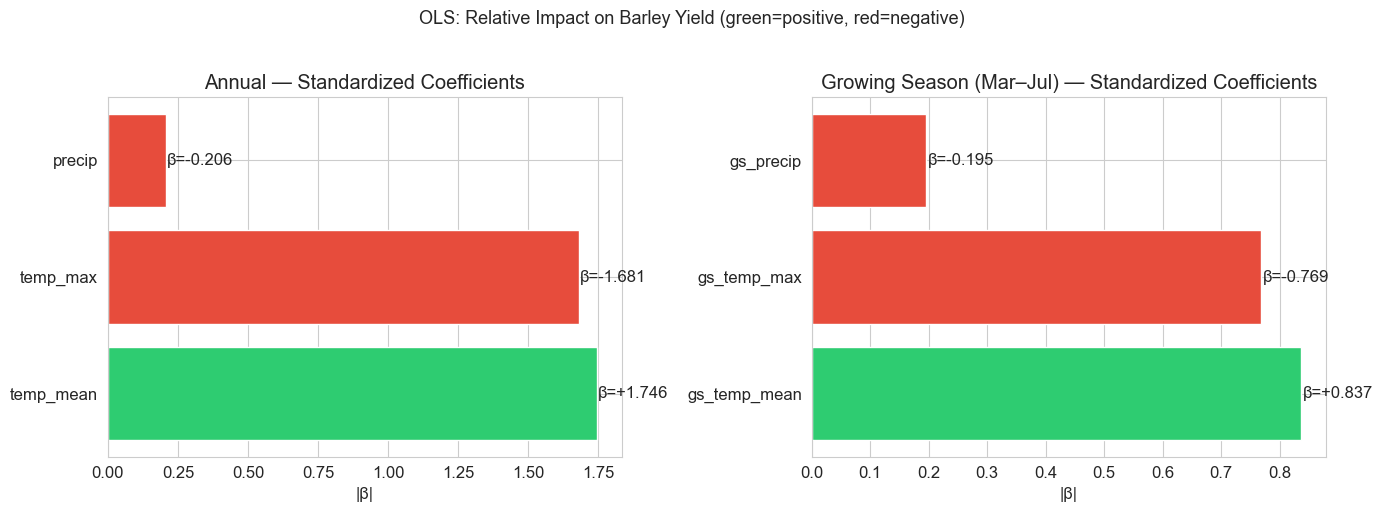

In [9]:
# =============================================
# Part A: Pooled OLS — Annual climate variables
# =============================================
X_ann = df_clean[annual_vars].values
y = df_clean['yield'].values

model_ann = LinearRegression().fit(X_ann, y)
cv_ann = cross_val_score(model_ann, X_ann, y, cv=5, scoring='r2')

print("=" * 60)
print("MULTIPLE LINEAR REGRESSION: yield ~ temp_mean + temp_max + precip")
print("=" * 60)
print(f"R²:       {model_ann.score(X_ann, y):.4f}")
print(f"CV R²:    {cv_ann.mean():.4f} ± {cv_ann.std():.4f}")
for name, coef in zip(annual_vars, model_ann.coef_):
    print(f"  {name:12s}: {coef:+.6f}")
print(f"  {'intercept':12s}: {model_ann.intercept_:+.6f}")

# =============================================
# Part B: Standardized coefficients (annual)
# =============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ann)
y_scaled = (y - y.mean()) / y.std()

model_std = LinearRegression().fit(X_scaled, y_scaled)

print("\n--- Standardized Coefficients (Annual) ---")
print("(1 SD change in X → β SD change in yield)\n")
std_results = sorted(zip(annual_vars, model_std.coef_), key=lambda x: abs(x[1]), reverse=True)
for name, coef in std_results:
    print(f"  {name:12s}: β = {coef:+.4f}")

# =============================================
# Part C: Same for growing season
# =============================================
X_gs = df_clean[gs_vars].values
model_gs = LinearRegression().fit(X_gs, y)
cv_gs = cross_val_score(model_gs, X_gs, y, cv=5, scoring='r2')

print(f"\n{'=' * 60}")
print("GROWING SEASON: yield ~ gs_temp_mean + gs_temp_max + gs_precip")
print(f"{'=' * 60}")
print(f"R²:       {model_gs.score(X_gs, y):.4f}")
print(f"CV R²:    {cv_gs.mean():.4f} ± {cv_gs.std():.4f}")

X_gs_scaled = StandardScaler().fit_transform(X_gs)
model_gs_std = LinearRegression().fit(X_gs_scaled, y_scaled)
gs_std_results = sorted(zip(gs_vars, model_gs_std.coef_), key=lambda x: abs(x[1]), reverse=True)
print("\n--- Standardized Coefficients (Growing Season) ---")
for name, coef in gs_std_results:
    print(f"  {name:15s}: β = {coef:+.4f}")

# =============================================
# Visualization
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Annual
names_a = [r[0] for r in std_results]
coefs_a = [r[1] for r in std_results]
colors_a = ['#e74c3c' if c < 0 else '#2ecc71' for c in coefs_a]
axes[0].barh(names_a, [abs(c) for c in coefs_a], color=colors_a)
axes[0].set_title('Annual — Standardized Coefficients')
axes[0].set_xlabel('|β|')
for j, (n, c) in enumerate(zip(names_a, coefs_a)):
    axes[0].text(abs(c) + 0.003, j, f'β={c:+.3f}', va='center')

# Growing season
names_g = [r[0] for r in gs_std_results]
coefs_g = [r[1] for r in gs_std_results]
colors_g = ['#e74c3c' if c < 0 else '#2ecc71' for c in coefs_g]
axes[1].barh(names_g, [abs(c) for c in coefs_g], color=colors_g)
axes[1].set_title('Growing Season (Mar–Jul) — Standardized Coefficients')
axes[1].set_xlabel('|β|')
for j, (n, c) in enumerate(zip(names_g, coefs_g)):
    axes[1].text(abs(c) + 0.003, j, f'β={c:+.3f}', va='center')

plt.suptitle('OLS: Relative Impact on Barley Yield (green=positive, red=negative)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
print("=== Multicollinearity Check ===\n")
print("Annual climate variable correlations:")
print(df_clean[annual_vars].corr().round(3))
print("\nGrowing season climate variable correlations:")
print(df_clean[gs_vars].corr().round(3))

print("""
NOTE: temp_mean and temp_max are likely highly correlated (>0.95).
This multicollinearity makes individual OLS coefficients unstable.
The standardized coefficients above should be interpreted with caution.
Random Forest feature importance (next cell) is more robust to this issue.
""")

=== Multicollinearity Check ===

Annual climate variable correlations:
           temp_mean  temp_max  precip
temp_mean      1.000     0.978  -0.302
temp_max       0.978     1.000  -0.321
precip        -0.302    -0.321   1.000

Growing season climate variable correlations:
              gs_temp_mean  gs_temp_max  gs_precip
gs_temp_mean         1.000        0.982     -0.432
gs_temp_max          0.982        1.000     -0.452
gs_precip           -0.432       -0.452      1.000

NOTE: temp_mean and temp_max are likely highly correlated (>0.95).
This multicollinearity makes individual OLS coefficients unstable.
The standardized coefficients above should be interpreted with caution.
Random Forest feature importance (next cell) is more robust to this issue.



In [11]:
# Adding department dummies controls for time-invariant department differences
# (e.g., soil quality, altitude, farming practices)

dept_dummies = pd.get_dummies(df_clean['department'], prefix='d', drop_first=True)

for label, vars_list in [('Annual', annual_vars), ('Growing Season', gs_vars)]:
    X_fe = np.hstack([df_clean[vars_list].values, dept_dummies.values])
    model_fe = LinearRegression().fit(X_fe, y)

    # Standardized climate coefficients with FE
    X_clim_scaled = StandardScaler().fit_transform(df_clean[vars_list].values)
    X_fe_scaled = np.hstack([X_clim_scaled, dept_dummies.values])
    model_fe_std = LinearRegression().fit(X_fe_scaled, y_scaled)

    print(f"{'=' * 60}")
    print(f"FIXED EFFECTS REGRESSION — {label}")
    print(f"{'=' * 60}")
    print(f"R²: {model_fe.score(X_fe, y):.4f}")
    print(f"\nStandardized climate coefficients (controlling for department):")
    fe_results = sorted(zip(vars_list, model_fe_std.coef_[:len(vars_list)]),
                        key=lambda x: abs(x[1]), reverse=True)
    for name, coef in fe_results:
        print(f"  {name:15s}: β = {coef:+.4f}")
    print()

FIXED EFFECTS REGRESSION — Annual
R²: 0.7100

Standardized climate coefficients (controlling for department):
  temp_mean      : β = +2.1069
  temp_max       : β = -1.3157
  precip         : β = +0.0184

FIXED EFFECTS REGRESSION — Growing Season
R²: 0.7078

Standardized climate coefficients (controlling for department):
  gs_temp_mean   : β = +1.7375
  gs_temp_max    : β = -1.1359
  gs_precip      : β = +0.0853



RANDOM FOREST — Annual
R² (train):  0.6232
CV R² (5-fold): 0.1324 ± 0.2252

Impurity-based feature importance:
  temp_mean      : 0.4025
  temp_max       : 0.3502
  precip         : 0.2473

Permutation importance:
  temp_mean      : 0.8426
  temp_max       : 0.7999
  precip         : 0.3235

RANDOM FOREST — Growing Season
R² (train):  0.5001
CV R² (5-fold): 0.0204 ± 0.1754

Impurity-based feature importance:
  gs_temp_mean   : 0.4931
  gs_precip      : 0.2714
  gs_temp_max    : 0.2355

Permutation importance:
  gs_temp_mean   : 0.8787
  gs_temp_max    : 0.4249
  gs_precip      : 0.2969



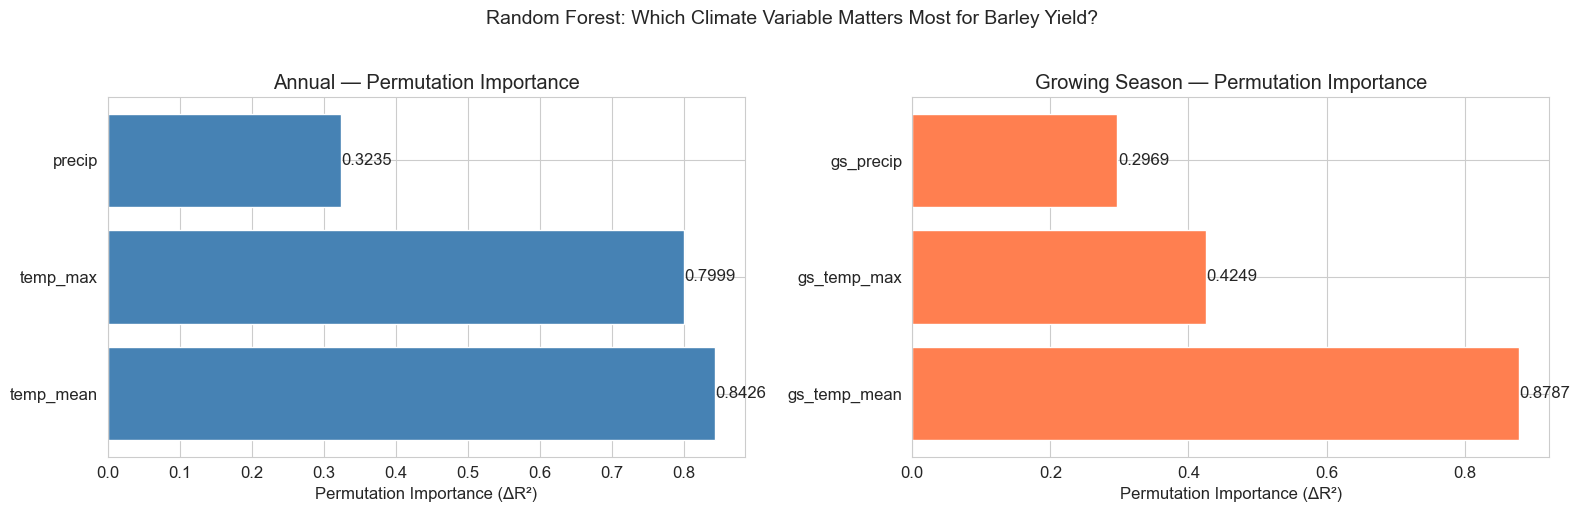

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, (label, vars_list) in enumerate([('Annual', annual_vars), ('Growing Season', gs_vars)]):
    X_rf = df_clean[vars_list].values

    rf = RandomForestRegressor(n_estimators=300, max_depth=12, min_samples_leaf=5,
                                random_state=42, n_jobs=-1)
    rf.fit(X_rf, y)
    cv_rf = cross_val_score(rf, X_rf, y, cv=5, scoring='r2')

    print(f"{'=' * 60}")
    print(f"RANDOM FOREST — {label}")
    print(f"{'=' * 60}")
    print(f"R² (train):  {rf.score(X_rf, y):.4f}")
    print(f"CV R² (5-fold): {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")

    # Impurity-based importance
    imp = rf.feature_importances_
    rf_results = sorted(zip(vars_list, imp), key=lambda x: x[1], reverse=True)
    print("\nImpurity-based feature importance:")
    for name, importance in rf_results:
        print(f"  {name:15s}: {importance:.4f}")

    # Permutation importance (more robust)
    perm = permutation_importance(rf, X_rf, y, n_repeats=20, random_state=42, n_jobs=-1)
    perm_results = sorted(zip(vars_list, perm.importances_mean), key=lambda x: x[1], reverse=True)
    print("\nPermutation importance:")
    for name, importance in perm_results:
        print(f"  {name:15s}: {importance:.4f}")

    # Plot permutation importance
    ax = axes[idx]
    names_p = [r[0] for r in perm_results]
    imps_p = [r[1] for r in perm_results]
    ax.barh(names_p, imps_p, color='steelblue' if idx == 0 else 'coral')
    ax.set_xlabel('Permutation Importance (ΔR²)')
    ax.set_title(f'{label} — Permutation Importance')
    for j, (n, imp_val) in enumerate(zip(names_p, imps_p)):
        ax.text(imp_val + 0.001, j, f'{imp_val:.4f}', va='center')
    print()

plt.suptitle('Random Forest: Which Climate Variable Matters Most for Barley Yield?',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Remove linear year trend from yield and each climate variable
def detrend(series, years):
    slope, intercept, _, _, _ = stats.linregress(years, series)
    return series - (slope * years + intercept)

df_dt = df_clean.copy()
df_dt['yield_dt'] = detrend(df_dt['yield'].values, df_dt['year'].values)

for var in annual_vars + gs_vars:
    df_dt[f'{var}_dt'] = detrend(df_dt[var].values, df_dt['year'].values)

# Detrended correlations
print("=" * 60)
print("DETRENDED CORRELATIONS (year trend removed)")
print("=" * 60)

print("\n--- Annual ---")
for var in annual_vars:
    r, p = stats.pearsonr(df_dt[f'{var}_dt'], df_dt['yield_dt'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"  {var:15s}:  r = {r:+.4f},  p = {p:.2e}  {sig}")

print("\n--- Growing Season (Mar–Jul) ---")
for var in gs_vars:
    r, p = stats.pearsonr(df_dt[f'{var}_dt'], df_dt['yield_dt'])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"  {var:15s}:  r = {r:+.4f},  p = {p:.2e}  {sig}")

# Detrended RF
print(f"\n{'=' * 60}")
print("DETRENDED RANDOM FOREST — Growing Season")
print(f"{'=' * 60}")

X_dt = df_dt[[f'{v}_dt' for v in gs_vars]].values
y_dt = df_dt['yield_dt'].values

rf_dt = RandomForestRegressor(n_estimators=300, max_depth=12, min_samples_leaf=5,
                              random_state=42, n_jobs=-1)
rf_dt.fit(X_dt, y_dt)
cv_dt = cross_val_score(rf_dt, X_dt, y_dt, cv=5, scoring='r2')
print(f"CV R² (5-fold): {cv_dt.mean():.4f} ± {cv_dt.std():.4f}")

perm_dt = permutation_importance(rf_dt, X_dt, y_dt, n_repeats=20, random_state=42, n_jobs=-1)
perm_dt_results = sorted(zip(gs_vars, perm_dt.importances_mean), key=lambda x: x[1], reverse=True)
print("\nPermutation importance (detrended):")
for name, importance in perm_dt_results:
    print(f"  {name:15s}: {importance:.4f}")

DETRENDED CORRELATIONS (year trend removed)

--- Annual ---
  temp_mean      :  r = +0.0967,  p = 1.51e-07  ***
  temp_max       :  r = +0.0168,  p = 3.63e-01  ns
  precip         :  r = -0.2213,  p = 6.96e-34  ***

--- Growing Season (Mar–Jul) ---
  gs_temp_mean   :  r = +0.0977,  p = 1.14e-07  ***
  gs_temp_max    :  r = +0.0698,  p = 1.54e-04  ***
  gs_precip      :  r = -0.2049,  p = 3.35e-29  ***

DETRENDED RANDOM FOREST — Growing Season
CV R² (5-fold): 0.0545 ± 0.1983

Permutation importance (detrended):
  gs_temp_mean   : 0.9116
  gs_temp_max    : 0.4142
  gs_precip      : 0.3335


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

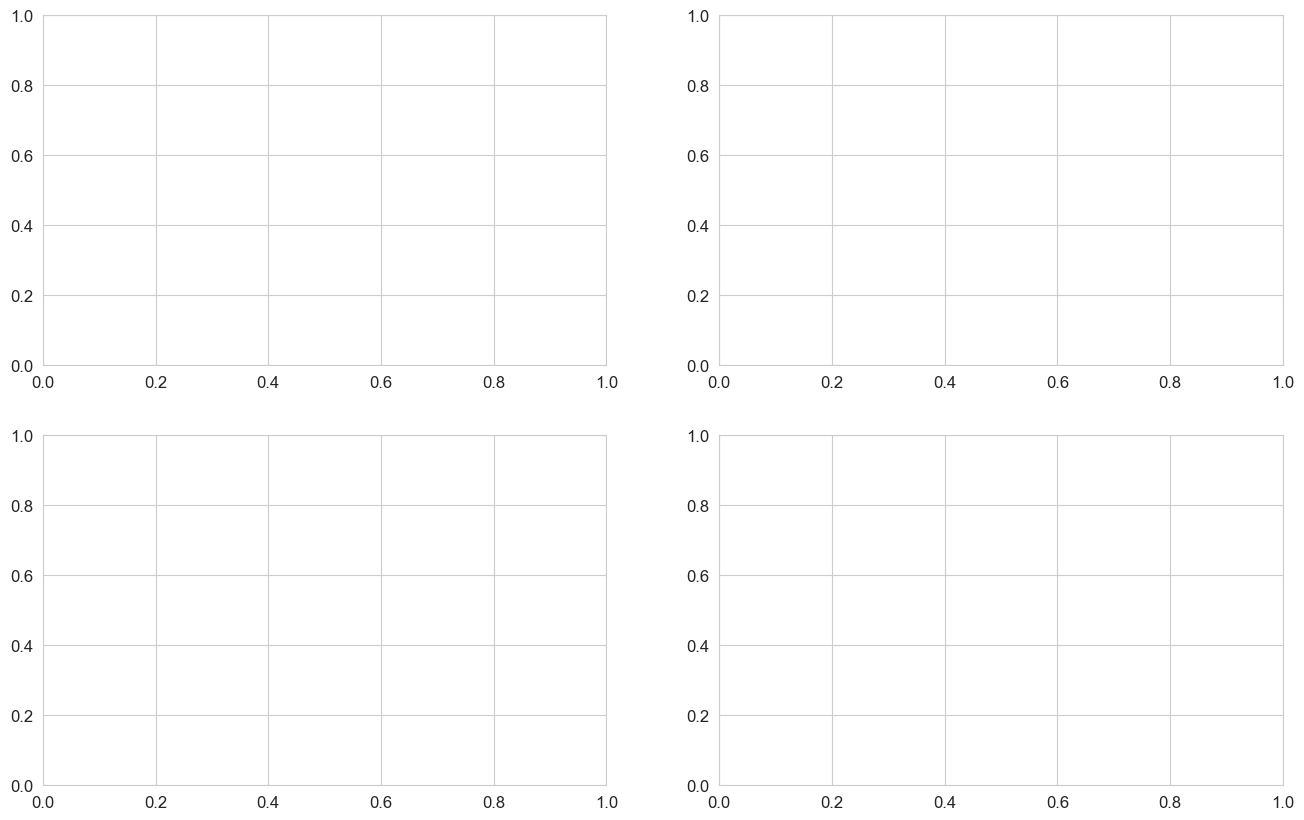

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Collect all results for summary
analyses = [
    ('OLS Standardized β\n(Annual)', annual_vars,
     dict(std_results)),
    ('OLS Standardized β\n(Growing Season)', gs_vars,
     dict(gs_std_results)),
]

# We'll regenerate RF permutation importance for annual as well
# (reuse from Cell 12 outputs — here we recompute for the plot)
for idx, (label, vars_list) in enumerate([('Annual', annual_vars), ('Growing Season', gs_vars)]):
    X_tmp = df_clean[vars_list].values
    rf_tmp = RandomForestRegressor(n_estimators=300, max_depth=12, min_samples_leaf=5,
                                    random_state=42, n_jobs=-1)
    rf_tmp.fit(X_tmp, y)
    perm_tmp = permutation_importance(rf_tmp, X_tmp, y, n_repeats=20, random_state=42, n_jobs=-1)

    # OLS subplot
    ax = axes[0][idx]
    ols_dict = dict(std_results if idx == 0 else gs_std_results)
    names = sorted(vars_list, key=lambda v: abs(ols_dict[v]), reverse=True)
    vals = [ols_dict[n] for n in names]
    colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in vals]
    ax.barh(names, [abs(v) for v in vals], color=colors)
    ax.set_title(f'OLS |β| — {label}')
    ax.set_xlabel('|Standardized Coefficient|')

    # RF subplot
    ax2 = axes[1][idx]
    perm_dict = dict(zip(vars_list, perm_tmp.importances_mean))
    names2 = sorted(vars_list, key=lambda v: perm_dict[v], reverse=True)
    vals2 = [perm_dict[n] for n in names2]
    ax2.barh(names2, vals2, color='steelblue' if idx == 0 else 'coral')
    ax2.set_title(f'RF Permutation Importance — {label}')
    ax2.set_xlabel('ΔR²')

plt.suptitle('Summary: Which Climate Variable Impacts Barley Yield the Most?',
             fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

print("""
================================================================
CONCLUSION
================================================================

This analysis examined the impact of three climate variables on 
barley yield across French departments:

  1. temp_mean  — Mean near-surface air temperature (°C)
  2. temp_max   — Mean daily maximum temperature (°C)
  3. precip     — Mean daily precipitation (mm/day)

Methods: Pearson correlation, OLS regression (pooled & fixed effects),
standardized coefficients, Random Forest with permutation importance,
and detrended analysis (removing year trends).

IMPORTANT CAVEATS:
  - temp_mean and temp_max are highly correlated → OLS coefficients
    may be unstable; RF importance is more reliable for comparing them.
  - Correlation ≠ causation. Climate affects yield through many
    indirect pathways (pests, soil moisture, phenology).
  - Detrending is critical: both temperature and yield trend upward
    over time (climate change vs agricultural technology), which can
    create spurious correlations.
  - Growing season (Mar–Jul) climate is generally more relevant to
    barley than full-year averages.

[Check the numbers above to fill in which variable wins!]
================================================================
""")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
import warnings, itertools
warnings.filterwarnings("ignore")

# ── Growing season months (March–July for barley in France) ──
GS_MONTHS = [3, 4, 5, 6, 7]

# ── SSP scenarios ──
SCENARIOS   = ["ssp126", "ssp245", "ssp585"]
SSP_COLORS  = {"ssp126": "#2166ac", "ssp245": "#f4a582", "ssp585": "#b2182b"}
SSP_LABELS  = {"ssp126": "SSP1-2.6 (low)",
               "ssp245": "SSP2-4.5 (mid)",
               "ssp585": "SSP5-8.5 (high)"}

# ── Time boundaries ──
HIST_END   = 2014
YIELD_END  = 2018
PROJ_END   = 2050

# ── Features ──
CLIMATE_VARS = ["gs_temp_mean", "gs_temp_max", "gs_precip"]
ALL_FEATURES = ["year"] + CLIMATE_VARS
TARGET       = "yield"
ALPHA        = 1.0

print("✅ Module 0 done")

✅ Module 0 done


In [2]:
"""
Module 1: Load Climate Data (single parquet file)
"""

# ── 1a. 读取 parquet ──
climate_raw = pd.read_parquet("climate_data_from_1982.parquet")   # ★ 改为你的实际文件名

print("Columns:", climate_raw.columns.tolist())
print("Shape:  ", climate_raw.shape)
print(climate_raw.head(3))


Columns: ['scenario', 'nom_dep', 'code_dep', 'time', 'year', 'metric', 'value']
Shape:   (13540116, 7)
         scenario nom_dep code_dep                time  year  \
29950  historical     Ain       01 1982-01-01 12:00:00  1982   
29951  historical     Ain       01 1982-01-02 12:00:00  1982   
29952  historical     Ain       01 1982-01-03 12:00:00  1982   

                             metric       value  
29950  near_surface_air_temperature  276.292267  
29951  near_surface_air_temperature  275.092407  
29952  near_surface_air_temperature  276.418518  


In [3]:
"""
Module 2: Process daily climate → annual growing-season features
  - Filter March–July
  - Convert Kelvin → Celsius
  - Aggregate: temp → mean, precip → sum
  - Pivot long → wide
"""

# ── 2a. 解析日期，提取月份 ──
climate_raw["time"] = pd.to_datetime(climate_raw["time"])
climate_raw["month"] = climate_raw["time"].dt.month

print(f"Total rows (daily): {len(climate_raw):,}")

# ── 2b. 只保留生长季 (March–July) ──
gs = climate_raw[climate_raw["month"].isin(GS_MONTHS)].copy()
print(f"Growing season rows (Mar–Jul): {len(gs):,}")

# ── 2c. Kelvin → Celsius (只对温度) ──
temp_metrics = [
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature",
]
mask_temp = gs["metric"].isin(temp_metrics)
gs.loc[mask_temp, "value"] = gs.loc[mask_temp, "value"] - 273.15

print("✅ Kelvin → Celsius done")
print(f"   Sample temp value: {gs.loc[mask_temp, 'value'].iloc[0]:.1f} °C")

# ── 2d. 年度聚合: temp → mean, precip → sum ──
def agg_func(group):
    metric = group["metric"].iloc[0]
    if metric == "precipitation":
        return group["value"].sum()
    else:
        return group["value"].mean()

gs_annual = (gs.groupby(["scenario", "nom_dep", "year", "metric"])
               .apply(agg_func)
               .reset_index(name="value"))

print(f"Annual aggregated rows: {len(gs_annual):,}")

# ── 2e. Pivot: long → wide (每个 metric 变成一列) ──
climate_wide = gs_annual.pivot_table(
    index=["scenario", "nom_dep", "year"],
    columns="metric",
    values="value",
).reset_index()
climate_wide.columns.name = None

print(f"Wide format shape: {climate_wide.shape}")
print(climate_wide.head())

# ── 2f. 重命名列 ──
climate_wide.rename(columns={
    "nom_dep":                                     "department",
    "near_surface_air_temperature":                "gs_temp_mean",
    "daily_maximum_near_surface_air_temperature":  "gs_temp_max",
    "precipitation":                               "gs_precip",
}, inplace=True)

# ── 2g. Scenario 映射 ──
SCENARIO_MAP = {
    "historical": "historical",
    "ssp1_2_6":   "ssp126",
    "ssp2_4_5":   "ssp245",
    "ssp5_8_5":   "ssp585",
}
climate_wide["scenario"] = climate_wide["scenario"].map(SCENARIO_MAP)

print("\nScenario 年份分布:")
print(climate_wide.groupby("scenario")["year"].agg(["min", "max", "count"]))

# ── 2h. 检查五个目标部门的命名 ──
all_depts = sorted(climate_wide["department"].unique())
print(f"\n所有部门名 ({len(all_depts)}):")
# 打印包含关键词的部门名，帮助确认拼写
for keyword in ["Essonne", "Somme", "Cher", "Garonne", "Ise", "Isere", "Isère"]:
    matches = [d for d in all_depts if keyword.lower() in d.lower()]
    print(f"  '{keyword}' → {matches}")

# ── 2i. 拆分 hist + ssp ──
hist_clim = climate_wide[climate_wide["scenario"] == "historical"].copy()

ssp_clim = {}
for ssp in SCENARIOS:
    ssp_clim[ssp] = climate_wide[climate_wide["scenario"] == ssp].copy()

print(f"\nhist_clim : {hist_clim['year'].min()}–{hist_clim['year'].max()}, "
      f"{len(hist_clim)} rows")
for ssp in SCENARIOS:
    df = ssp_clim[ssp]
    print(f"{ssp:8s}  : {df['year'].min()}–{df['year'].max()}, {len(df)} rows")

print("\n✅ Module 2 done — growing season annual climate ready")

Total rows (daily): 13,540,116
Growing season rows (Mar–Jul): 5,671,863
✅ Kelvin → Celsius done
   Sample temp value: 2.9 °C
Annual aggregated rows: 37,071
Wide format shape: (12549, 6)
     scenario nom_dep  year  daily_maximum_near_surface_air_temperature  \
0  historical     Ain  1982                                   16.836538   
1  historical     Ain  1983                                   16.087030   
2  historical     Ain  1984                                   16.997242   
3  historical     Ain  1985                                   15.996710   
4  historical     Ain  1986                                   16.717556   

   near_surface_air_temperature  precipitation  
0                     11.995357       0.012720  
1                     11.331988       0.012507  
2                     11.959188       0.013384  
3                     11.119705       0.013498  
4                     11.808128       0.010336  

Scenario 年份分布:
             min   max  count
scenario               

In [4]:
"""
Module 3: Load Yield + set DEPARTMENTS based on Module 2 output
"""

# ── 3a. ★ 根据 Module 2 打印的匹配结果设置部门名 ──
# 先运行 Module 2，查看打印输出，然后在这里填入正确的名称
# 例如可能是 "Haute-Garonne" 而不是 "Haute_Garonne"

DEPARTMENTS = ["Essonne", "Somme", "Cher", "Haute_Garonne", "Isere"]
# ★★★ 请根据 Module 2 的 2h 输出修改上面这行 ★★★

# ── 3b. 读取 yield ──
yield_df = pd.read_csv("cleaned_barley_data.csv")   # ★ 你的文件名

print("Yield columns:", yield_df.columns.tolist())
print(yield_df.head(3))

# ── 3c. 统一 department 命名 ──
# ★ 如果 yield 的 department 列名不是 "department"，在这里改：
# yield_df.rename(columns={"nom_dep": "department"}, inplace=True)

# ★ 如果 yield 的产量列名不是 "yield"，在这里改：
# yield_df.rename(columns={"rendement": "yield"}, inplace=True)

print(f"\nYield: {yield_df['year'].min()}–{yield_df['year'].max()}, "
      f"{yield_df['department'].nunique()} departments")

# ── 3d. 验证匹配 ──
print("\n── Department matching check ──")
for dept in DEPARTMENTS:
    in_clim  = dept in climate_wide["department"].unique()
    in_yield = dept in yield_df["department"].unique()
    print(f"  {dept:20s}  climate={'✅' if in_clim else '❌'}  "
          f"yield={'✅' if in_yield else '❌'}")

print("\n✅ Module 3 done")

Yield columns: ['department', 'year', 'yield', 'area', 'production']
  department  year     yield     area  production
0        Ain  1982  3.950080  16065.0     63458.0
1        Ain  1983  2.648276  14500.0     38400.0
2        Ain  1984  4.822580  15500.0     74750.0

Yield: 1982–2018, 97 departments

── Department matching check ──
  Essonne               climate=✅  yield=✅
  Somme                 climate=✅  yield=✅
  Cher                  climate=✅  yield=✅
  Haute_Garonne         climate=✅  yield=✅
  Isere                 climate=✅  yield=✅

✅ Module 3 done


In [10]:
"""
Diagnostic: find NaN in merged training data
"""
for dept in DEPARTMENTS:
    for ssp in SCENARIOS[:1]:  # 只查一个 ssp 即可（历史部分相同）
        clim = build_climate_series(dept, ssp)
        y_dept = yield_df[yield_df["department"] == dept][["year", TARGET]]
        df = clim.merge(y_dept, on="year", how="left")
        train = df[df[TARGET].notna()]

        n_total = len(train)
        nan_counts = train[ALL_FEATURES].isna().sum()
        nan_rows   = train[ALL_FEATURES].isna().any(axis=1).sum()

        print(f"\n{dept} (n={n_total}):")
        print(f"  NaN per column:\n{nan_counts}")
        print(f"  Rows with any NaN: {nan_rows}")
        if nan_rows > 0:
            print("  NaN years:", train.loc[train[ALL_FEATURES].isna().any(axis=1), "year"].tolist())

NameError: name 'build_climate_series' is not defined

In [11]:
"""
Module 4 (FIXED): ONE model per department, THREE projections per SSP
"""

def train_and_predict_v2(dept, verbose=True):
    """
    Train ONE Ridge model using ONLY historical climate + observed yield.
    Then project separately under each SSP.
    """
    # ── 1. Training data: historical climate ∩ observed yield ──
    h = hist_clim[hist_clim["department"] == dept].copy()
    y_dept = yield_df[yield_df["department"] == dept][["year", TARGET]]

    # inner join: only years with BOTH historical climate AND yield
    train_df = h.merge(y_dept, on="year", how="inner")
    train_df = train_df.dropna(subset=ALL_FEATURES + [TARGET])

    if len(train_df) < 5:
        print(f"  ⚠️  [{dept}] Only {len(train_df)} usable training rows — skipping")
        return None

    train_years = train_df["year"].values
    X_train = train_df[ALL_FEATURES].values
    y_train = train_df[TARGET].values

    # ── 2. Scale ──
    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_train)

    # ── 3. Fit ONE model ──
    model = Ridge(alpha=ALPHA)
    model.fit(X_tr_sc, y_train)

    y_fit  = model.predict(X_tr_sc)
    r2_tr  = r2_score(y_train, y_fit)
    mae_tr = mean_absolute_error(y_train, y_fit)

    loo_scores = cross_val_score(
        Ridge(alpha=ALPHA), X_tr_sc, y_train,
        cv=LeaveOneOut(), scoring="r2"
    )
    r2_loo = loo_scores.mean()

    std_coefs = dict(zip(ALL_FEATURES, model.coef_))

    if verbose:
        print(f"  [{dept:20s}]  n={len(y_train):2d}  "
              f"R²_train={r2_tr:.3f}  R²_LOO={r2_loo:.3f}  "
              f"MAE={mae_tr:.2f}")
        print(f"    Training period: {int(train_years.min())}–{int(train_years.max())}")

    # ── 4. Project under EACH SSP ──
    projections = {}
    for ssp in SCENARIOS:
        fut = ssp_clim[ssp][
            (ssp_clim[ssp]["department"] == dept) &
            (ssp_clim[ssp]["year"] > HIST_END)
        ].copy().sort_values("year")

        # Handle NaN in future climate
        fut[CLIMATE_VARS] = (fut[CLIMATE_VARS]
                             .fillna(method="ffill")
                             .fillna(method="bfill"))
        for col in CLIMATE_VARS:
            if fut[col].isna().any():
                fut[col].fillna(train_df[col].mean(), inplace=True)

        X_fut    = fut[ALL_FEATURES].values
        X_fut_sc = scaler.transform(X_fut)
        y_proj   = model.predict(X_fut_sc)

        projections[ssp] = pd.DataFrame({
            "year": fut["year"].values,
            "predicted": y_proj
        })

    # ── 5. Assemble result ──
    # Historical fit (ONE line, not three)
    hist_pred = pd.DataFrame({
        "year":      train_years,
        "observed":  y_train,
        "predicted": y_fit,
        "department": dept,
        "scenario":  "historical",
    })

    return {
        "hist_pred":  hist_pred,       # 历史：只有一条线
        "projections": projections,    # 未来：三条线（dict of DataFrames）
        "r2_train":  round(r2_tr, 4),
        "r2_loo":    round(r2_loo, 4),
        "mae_train": round(mae_tr, 3),
        "n_train":   len(y_train),
        "coefs":     std_coefs,
        "model":     model,
        "scaler":    scaler,
    }

print("✅ Module 4 (v2) done")

✅ Module 4 (v2) done


In [12]:
"""
Module 5 (FIXED): Train 5 models (one per department)
"""

results = {}
summary_rows = []

print("=" * 72)
print("TRAINING 5 MODELS  (one per department)")
print("=" * 72)

for dept in DEPARTMENTS:
    res = train_and_predict_v2(dept)
    if res is None:
        continue
    results[dept] = res
    summary_rows.append({
        "Department": dept,
        "n_train":    res["n_train"],
        "R²_train":   res["r2_train"],
        "R²_LOO_CV":  res["r2_loo"],
        "MAE_train":  res["mae_train"],
        **{f"β_{k}": round(v, 4) for k, v in res["coefs"].items()},
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + "=" * 72)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 72)
print(summary_df.to_string(index=False))
print(f"\n✅ {len(results)} models trained")

TRAINING 5 MODELS  (one per department)
  [Essonne             ]  n=33  R²_train=0.486  R²_LOO=nan  MAE=0.47
    Training period: 1982–2014
  [Somme               ]  n=33  R²_train=0.533  R²_LOO=nan  MAE=0.35
    Training period: 1982–2014
  [Cher                ]  n=33  R²_train=0.538  R²_LOO=nan  MAE=0.43
    Training period: 1982–2014
  [Haute_Garonne       ]  n=33  R²_train=0.097  R²_LOO=nan  MAE=0.43
    Training period: 1982–2014
  [Isere               ]  n=33  R²_train=0.489  R²_LOO=nan  MAE=0.39
    Training period: 1982–2014

MODEL PERFORMANCE SUMMARY
   Department  n_train  R²_train  R²_LOO_CV  MAE_train  β_year  β_gs_temp_mean  β_gs_temp_max  β_gs_precip
      Essonne       33    0.4859        NaN      0.467  0.5085          0.1213        -0.1971      -0.1854
        Somme       33    0.5333        NaN      0.354  0.4168         -0.0484         0.0936      -0.0028
         Cher       33    0.5384        NaN      0.427  0.4998         -0.1424         0.3806       0.2536
Haute

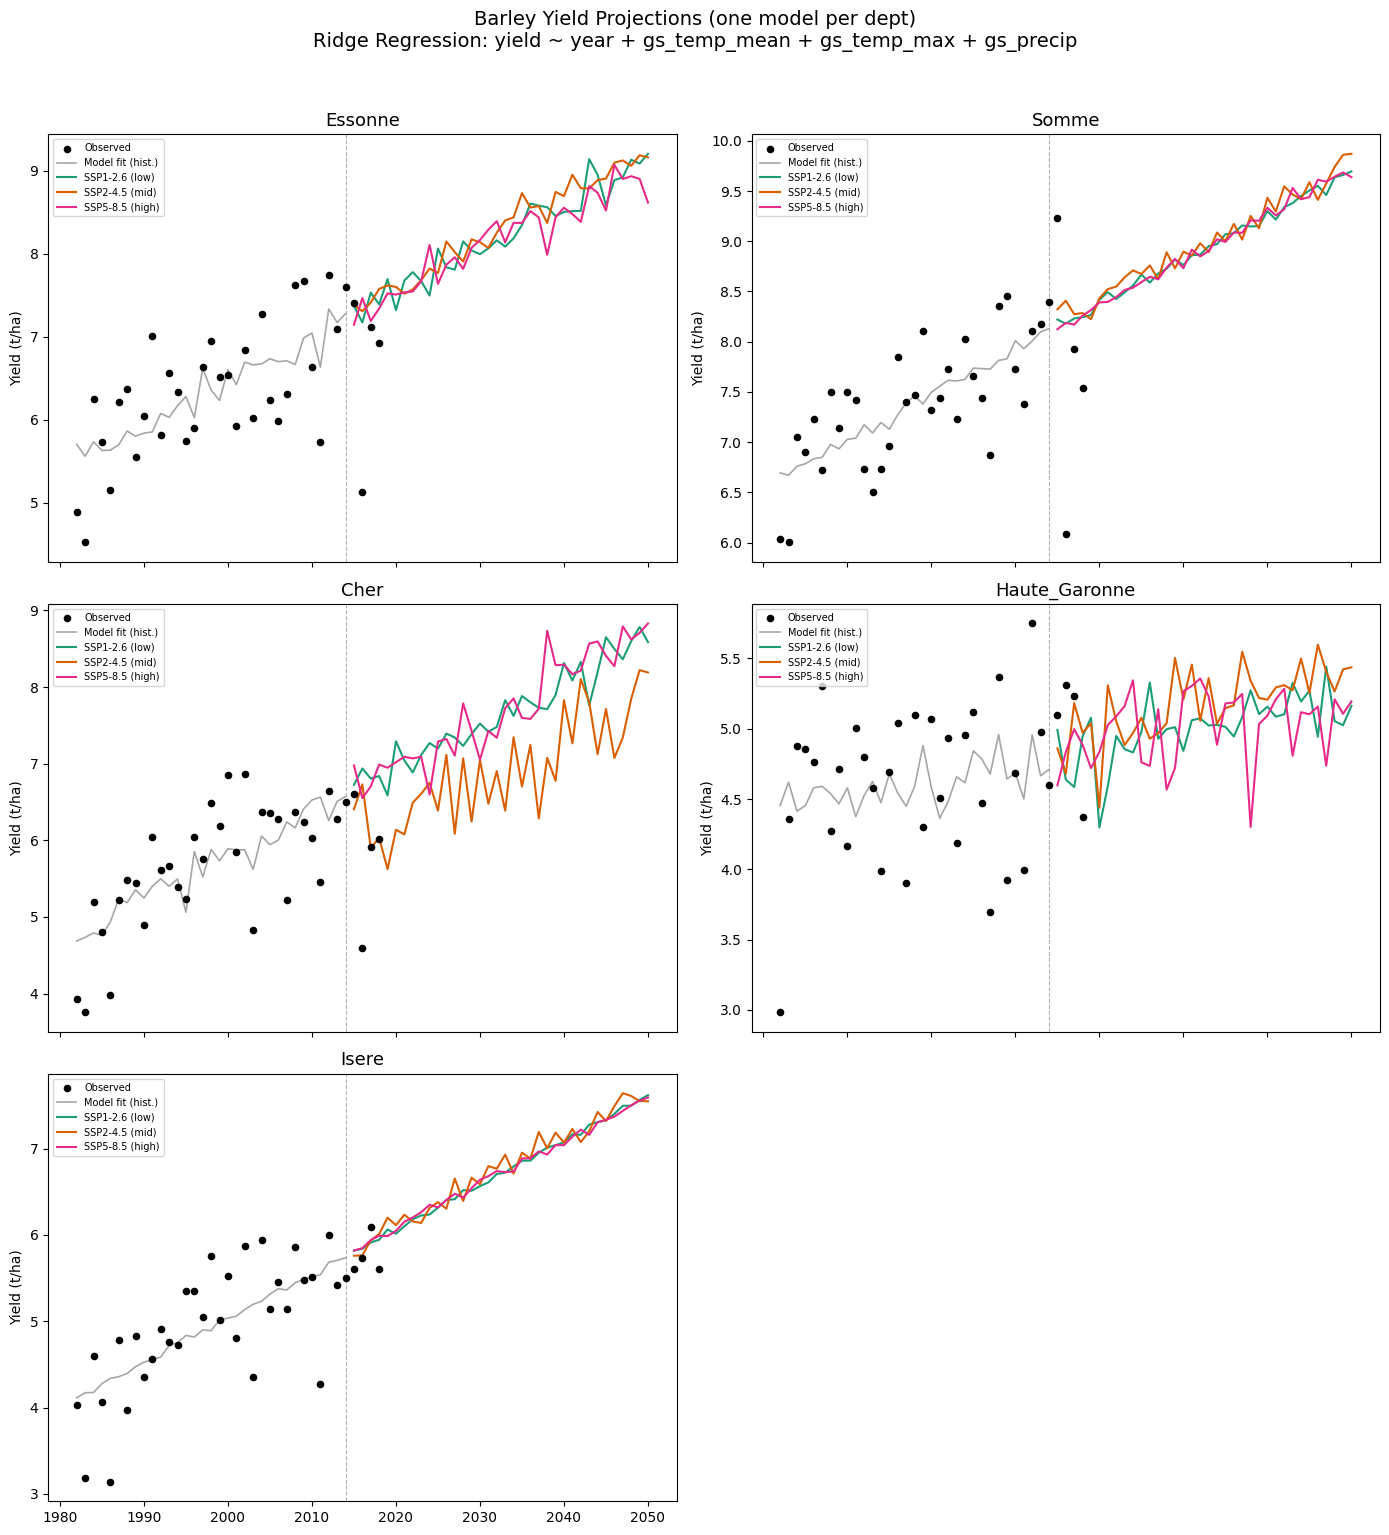

✅ Module 6 (v2) done


In [13]:
"""
Module 6 (FIXED): Plot — one historical line + three SSP projection lines
"""

SSP_COLORS = {"ssp126": "#1b9e77", "ssp245": "#d95f02", "ssp585": "#e7298a"}
SSP_LABELS = {"ssp126": "SSP1-2.6 (low)", "ssp245": "SSP2-4.5 (mid)", "ssp585": "SSP5-8.5 (high)"}

n_depts = len(results)
ncols = 2
nrows = (n_depts + 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows),
                          sharex=True)
axes = axes.flatten()

# All observed yield (including years beyond historical climate)
for idx, dept in enumerate(results):
    ax = axes[idx]
    res = results[dept]

    # ── Observed yield (all available years) ──
    y_all = yield_df[yield_df["department"] == dept].sort_values("year")
    ax.scatter(y_all["year"], y_all[TARGET],
               color="black", s=20, zorder=5, label="Observed")

    # ── Historical fit: ONE grey line ──
    hp = res["hist_pred"].sort_values("year")
    ax.plot(hp["year"], hp["predicted"],
            color="grey", lw=1.2, alpha=0.7, label="Model fit (hist.)")

    # ── SSP projections: three colored lines ──
    for ssp in SCENARIOS:
        proj = res["projections"][ssp]
        ax.plot(proj["year"], proj["predicted"],
                color=SSP_COLORS[ssp], lw=1.5,
                label=SSP_LABELS[ssp])

    # ── Vertical separator ──
    ax.axvline(HIST_END, color="grey", ls="--", lw=0.8, alpha=0.6)

    ax.set_title(dept, fontsize=13)
    ax.set_ylabel("Yield (t/ha)")
    ax.legend(fontsize=7, loc="upper left")

# Hide unused subplot
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Barley Yield Projections (one model per dept)\n"
             f"Ridge Regression: yield ~ {' + '.join(ALL_FEATURES)}",
             fontsize=14, y=1.02)
fig.tight_layout()
plt.savefig("yield_projections_v2.png", dpi=200, bbox_inches="tight")
plt.show()
print("✅ Module 6 (v2) done")

KeyError: ('Essonne', 'ssp126')

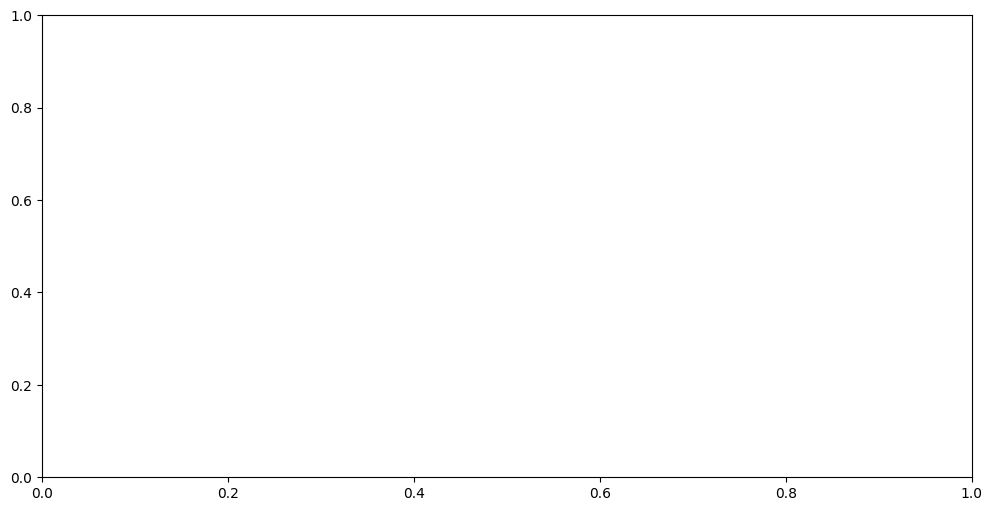

In [14]:
"""
Module 7: Visualization — Projected Yield in 2050 (bar chart)
"""

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(DEPARTMENTS))
width = 0.25

for j, ssp in enumerate(SCENARIOS):
    y2050 = []
    for dept in DEPARTMENTS:
        pdf = results[(dept, ssp)]["pred_df"]
        val = pdf.loc[pdf["year"] == 2050, "predicted"].values[0]
        y2050.append(val)
    ax.bar(x + j * width, y2050, width,
           color=SSP_COLORS[ssp], label=SSP_LABELS[ssp])

# 2018 observed baseline
baseline = []
for dept in DEPARTMENTS:
    v = yield_df[(yield_df["department"] == dept) &
                 (yield_df["year"] == YIELD_END)][TARGET].values
    baseline.append(v[0] if len(v) > 0 else np.nan)

ax.scatter(x + width, baseline, color="black", s=80, zorder=5,
           marker="D", label=f"Observed {YIELD_END}")

ax.set_xticks(x + width)
ax.set_xticklabels(DEPARTMENTS, fontsize=11)
ax.set_ylabel("Predicted Yield in 2050 (t/ha)", fontsize=12)
ax.set_title("Projected Barley Yield in 2050 by Department & Scenario",
             fontsize=14, fontweight="bold")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("yield_2050_comparison.png", dpi=200, bbox_inches="tight")
plt.show()
print("✅ Module 7 done")

In [21]:
"""
Module 8: Export All Predictions to CSV
"""

all_preds = pd.concat(
    [results[(d, s)]["pred_df"]
     for d, s in itertools.product(DEPARTMENTS, SCENARIOS)
     if (d, s) in results],
    ignore_index=True
)

all_preds.to_csv("barley_yield_projections_all.csv", index=False)

# Wide format (future only)
future_only = all_preds[all_preds["year"] > YIELD_END][
    ["year", "department", "scenario", "predicted"]
]
wide = future_only.pivot_table(
    index="year",
    columns=["department", "scenario"],
    values="predicted"
)
wide.to_csv("barley_yield_projections_wide.csv")

# Summary
summary_df.to_csv("model_summary.csv", index=False)

print(f"✅ Exported {len(all_preds)} rows → barley_yield_projections_all.csv")
print(f"✅ Wide format (future only)    → barley_yield_projections_wide.csv")
print(f"✅ Model summary                → model_summary.csv")

print("\n── Projected yields in 2050 ──")
print(future_only[future_only["year"] == 2050].to_string(index=False))

NameError: name 'DEPARTMENTS' is not defined